In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scanpy.api as sc
import pandas as pd
import h5py
import os
import time
import itertools
from sklearn.decomposition import PCA

import scanpy.api as sc
import sceb.data_loader as dl 
import sceb.scdd as sd

%matplotlib inline
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams

params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 10,
   'xtick.labelsize': 13,
   'ytick.labelsize': 13,
   'text.usetex': False,
   'text.usetex': False,
   }
rcParams.update(params)

/home/martin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Experiment details:
   - Includes 3 PBMC datasets.
   - The genes are filtered to have mean counts larger than 0.2.
   - The subsampled data is down sampled 4 times.
   - The number of genes for PCA analysis is 500 for PBMC_4k and PBMC_8k. Since PBMC_68k has only 687 genes above the threshold. We choose this number to be 300 to show the effect of feature selection.

In [2]:
output_folder = '/home/martin/single_cell_eb/figures/figure_feature_selection'
suffix='_PMBC_4k'
# suffix='_PMBC_8k'
# suffix='_PMBC_68k'

In [3]:
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

if suffix == '_PMBC_4k':
    data_raw = dl.load_10x_4k()
    n_gene = 500
elif suffix == '_PMBC_8k':
    data_raw = dl.load_10x_8k()
    n_gene = 500
elif suffix == '_PMBC_68k':
    data_raw = dl.load_10x_68k()
    n_gene = 300 ## There are very few genes for the 68k data, so we make this number smaller to shoe the difference

data_raw.var_names_make_unique()
data = sd.preprocess(data_raw)
sc.pp.filter_genes(data,min_counts=0.2*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)
print('## Nc=%d, G=%d, Nr=%0.1f'%(Nc,G,Nr))  
data_subsample = sd.subsample_anndata(data,Nr/4,Nc)
data_subsample = sd.preprocess(data_subsample)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
## Nc=4340, G=2131, Nr=3312.38, Nr_bar=1.55
## Nc=4340, G=2131, Nr=3312.4
#time start: 0.0s
before cell subsamp (4340, 2131)
after cell subsamp (4340, 2131)
#time sub-sample cells: 0.0536s
#time sub-sample counts: 10.1061s



# Estimation

In [4]:
# Estimation on the full data
size_factor = sd.dd_size_factor(data,verbose=False)
M_ml,M_dd = sd.dd_1d_moment(data,size_factor=size_factor)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)
rank_dd = sd.get_rank(cv_dd)
rank_ml = sd.get_rank(cv_ml)

# Estimation on the subsampled data 
size_factor = sd.dd_size_factor(data_subsample,verbose=False)
M_ml_sub,M_dd_sub  = sd.dd_1d_moment(data_subsample,size_factor=size_factor)
cv_dd_sub = sd.M_to_cv(M_dd_sub)
cv_ml_sub = sd.M_to_cv(M_ml_sub)
rank_dd_sub = sd.get_rank(cv_dd_sub)
rank_ml_sub = sd.get_rank(cv_ml_sub)

#time start: 0.0s
n_cell=4340, n_gene=2131
#total: 0.19s
#time start: 0.0s
n_cell=4340, n_gene=2131
#total: 0.02s


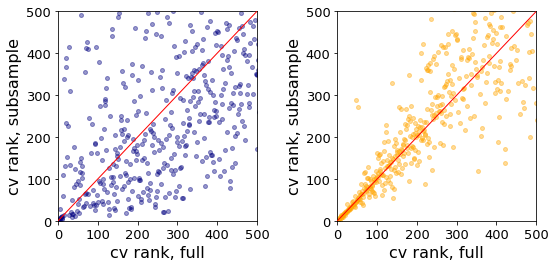

In [5]:
figsize=[8,4]

plt.figure(figsize=figsize)
plt.subplot(121)
sd.plot_xx(rank_ml,rank_ml_sub,logscale=False,color='navy',lim=[0,500,0,500],s=16,require_count=False)
plt.xlabel('cv rank, full')
plt.ylabel('cv rank, subsample')


plt.subplot(122)

# plt.figure(figsize=figsize)
sd.plot_xx(rank_dd,rank_dd_sub,logscale=False,lim=[0,500,0,500],s=16,require_count=False)

plt.xlabel('cv rank, full')
plt.ylabel('cv rank, subsample')

# plt.ylabel('CV rank in subsampled data')
# plt.title('EB')
# plt.suptitle('Consistency plot of CV rank')
plt.tight_layout()
plt.savefig(output_folder+'/rank_consistency'+suffix+'.png')
plt.savefig(output_folder+'/rank_consistency'+suffix+'.pdf')
plt.show()

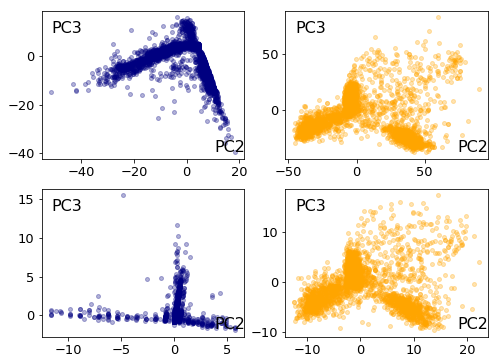

In [6]:
## PCA plot
figsize=[8,6]

# plug-in full
gene_list = np.array(data.var_names,dtype=str)
plt.figure(figsize=figsize)
plt.subplot(221)
temp = gene_list[rank_ml<n_gene]
data_sub = data[:,temp]
mean_,cov_,_  = sd.ml_covariance(data_sub,size_factor=None,verbose=False)
D_,V_ = np.linalg.eigh(cov_)
v1 = np.array(V_[:,-2]).reshape(-1)
v2 = np.array(V_[:,-3]).reshape(-1)
sd.plot_PCA_score(data_sub,v1,v2,color='navy')
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.annotate('PC3',[x_min+0.05*(x_max-x_min),y_max-0.15*(y_max-y_min)],fontsize=16)
plt.annotate('PC2',[x_max-0.15*(x_max-x_min),y_min+0.05*(y_max-y_min)],fontsize=16)

# EB, full
plt.subplot(222)
temp = gene_list[rank_dd<n_gene]
data_sub = data[:,temp]
mean_,cov_,_  = sd.dd_covariance(data_sub,size_factor=None,verbose=False)
D_,V_ = np.linalg.eigh(cov_)
v1 = np.array(V_[:,-2]).reshape(-1)
v2 = np.array(V_[:,-3]).reshape(-1)
sd.plot_PCA_score(data_sub,v1,v2,color='orange')
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.annotate('PC3',[x_min+0.05*(x_max-x_min),y_max-0.15*(y_max-y_min)],fontsize=16)
plt.annotate('PC2',[x_max-0.15*(x_max-x_min),y_min+0.05*(y_max-y_min)],fontsize=16)

# plug-in, sub
plt.subplot(223)
temp = gene_list[rank_ml_sub<n_gene]
data_sub = data_subsample[:,temp]
mean_,cov_,_  = sd.ml_covariance(data_sub,size_factor=None,verbose=False)
D_,V_ = np.linalg.eigh(cov_)
v1 = np.array(V_[:,-2]).reshape(-1)
v2 = np.array(V_[:,-3]).reshape(-1)
sd.plot_PCA_score(data_sub,v1,v2,color='navy')
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.annotate('PC3',[x_min+0.05*(x_max-x_min),y_max-0.15*(y_max-y_min)],fontsize=16)
plt.annotate('PC2',[x_max-0.15*(x_max-x_min),y_min+0.05*(y_max-y_min)],fontsize=16)

# EB, sub
plt.subplot(224)
temp = gene_list[rank_dd_sub<n_gene]
data_sub = data_subsample[:,temp]
mean_,cov_,_  = sd.dd_covariance(data_sub,size_factor=None,verbose=False)
D_,V_ = np.linalg.eigh(cov_)
v1 = -np.array(V_[:,-2]).reshape(-1)
v2 = -np.array(V_[:,-3]).reshape(-1)
sd.plot_PCA_score(data_sub,v1,v2,color='orange')
x_min,x_max = plt.xlim()
y_min,y_max = plt.ylim()
plt.annotate('PC3',[x_min+0.05*(x_max-x_min),y_max-0.15*(y_max-y_min)],fontsize=16)
plt.annotate('PC2',[x_max-0.15*(x_max-x_min),y_min+0.05*(y_max-y_min)],fontsize=16)
plt.savefig(output_folder+'/PCA_plot'+suffix+'.png')
plt.savefig(output_folder+'/PCA_plot'+suffix+'.pdf')
plt.show()

# old code

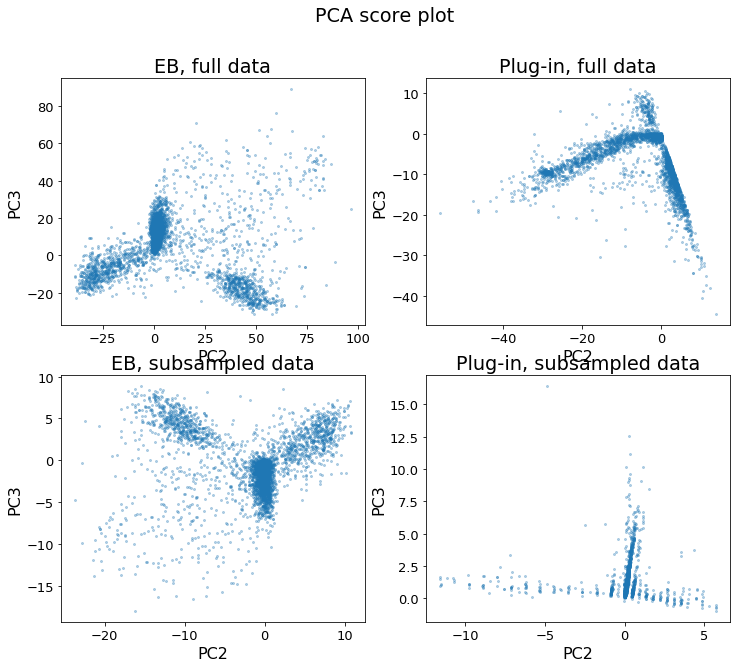

In [25]:
## PCA plot
gene_list = np.array(data.var_names,dtype=str)
plt.figure(figsize=[12,10])
plt.subplot(2,2,1)
temp = gene_list[rank_dd<n_gene]
data_sub = data[:,temp]
mean_,cov_,_  = sd.dd_covariance(data_sub,size_factor=None,verbose=False)
D_,V_ = np.linalg.eigh(cov_)
v1 = np.array(V_[:,-2]).reshape(-1)
v2 = np.array(V_[:,-3]).reshape(-1)
sd.plot_PCA_score(data_sub,v1,v2)
plt.title('EB, full data')
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(2,2,2)
temp = gene_list[rank_ml<n_gene]
data_sub = data[:,temp]
mean_,cov_,_  = sd.ml_covariance(data_sub,size_factor=None,verbose=False)
D_,V_ = np.linalg.eigh(cov_)
v1 = np.array(V_[:,-2]).reshape(-1)
v2 = np.array(V_[:,-3]).reshape(-1)
sd.plot_PCA_score(data_sub,v1,v2)
plt.title('Plug-in, full data')
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(2,2,3)
temp = gene_list[rank_dd_sub<n_gene]
data_sub = data_subsample[:,temp]
mean_,cov_,_  = sd.dd_covariance(data_sub,size_factor=None,verbose=False)
D_,V_ = np.linalg.eigh(cov_)
v1 = -np.array(V_[:,-2]).reshape(-1)
v2 = -np.array(V_[:,-3]).reshape(-1)
sd.plot_PCA_score(data_sub,v1,v2)
plt.title('EB, subsampled data')
plt.xlabel('PC2')
plt.ylabel('PC3')

plt.subplot(2,2,4)
temp = gene_list[rank_ml_sub<n_gene]
data_sub = data_subsample[:,temp]
mean_,cov_,_  = sd.ml_covariance(data_sub,size_factor=None,verbose=False)
D_,V_ = np.linalg.eigh(cov_)
v1 = np.array(V_[:,-2]).reshape(-1)
v2 = np.array(V_[:,-3]).reshape(-1)
sd.plot_PCA_score(data_sub,v1,v2)
plt.title('Plug-in, subsampled data')
plt.xlabel('PC2')
plt.ylabel('PC3')

# plt.suptitle('PCA score plot')
plt.savefig(output_folder+'/PCA_plot'+suffix+'.png')
plt.savefig(output_folder+'/PCA_plot'+suffix+'.pdf')
plt.show()

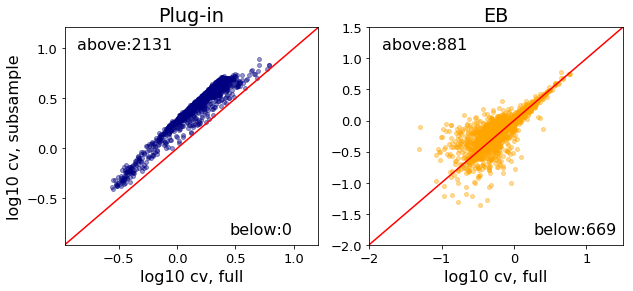

In [44]:
plt.figure(figsize=[10,4])
plt.subplot(121)
sd.plot_xx(cv_ml,cv_ml_sub,logscale=True,color='navy',s=16)
plt.xlabel('log10 cv, full')
plt.ylabel('log10 cv, subsample')
plt.title('Plug-in')
plt.subplot(122)
sd.plot_xx(cv_dd,cv_dd_sub,logscale=True,lim=[-2,1.5,-2,1.5],s=16)
plt.xlabel('log10 cv, full')
# plt.ylabel('log10 CV, subsampled data')
plt.title('EB')
# plt.suptitle('Consistency plot of CV')
plt.savefig(output_folder+'/cv_consistency_plot'+suffix+'.png')
plt.savefig(output_folder+'/cv_consistency_plot'+suffix+'.pdf')
plt.show()